# Ames House数据集上的回归分析

Ames房价预测是Kaggle平台上的一个竞赛任务，需要根据房屋的特征来预测亚美尼亚州洛瓦市（Ames，Lowa）的房价。其中房屋的特征x共有79维，响应值y为每个房屋的销售价格（SalePrice）。

Kaggle官网上的任务说明请见：
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

由于房屋的属性较多，且房屋属性类型各异，所以先对原数据集进行特征编码。特征工程过程请见FE_AmesHouse.ipynb


本代码直接在编码后的数据集上进行线性回归及其各种正则算法进行验证。

Kaggle平台上kernel区有各个竞赛参数者分享的代码，大家可以学习。
下面的代码也参考了很多不同选手分享的代码，在此一并致谢。

In [1]:
# 导入必要的工具包
# 数据读取及基本处理
import pandas as pd
import numpy as np

#模型
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

#模型评估
from sklearn.metrics import mean_squared_error

#可视化
import matplotlib.pyplot as plt

In [2]:
# 读入数据
train = pd.read_csv("AmesHouse_FE_train.csv")
print("train : " + str(train.shape))

test = pd.read_csv("AmesHouse_FE_test.csv")
print("test : " + str(test.shape))

train : (1456, 344)
test : (1459, 344)


**准备训练数据**

In [3]:
y_train = train["SalePrice"]
X_train = train.drop(['SalePrice'], axis = 1)

test_Id = test['Id']
X_test = test.drop(['Id'], axis = 1)

In [4]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 初始化对目标值的标准化器
# 对y标准化不是必须，但对其进行标准化可以使得不同问题w的取值范围相对相同

#自己实现试试...,这些参数需要保留，对测试集预测完后还需要对其进行反变换
mean_y = y_train.mean()
std_y = y_train.std()
y_train = (y_train - mean_y)/std_y

#ss_y = StandardScaler()
#y_train = ss_y.fit_transform(y_train.values.reshape(-1, 1))
#y_test = ss_y.transform(y_test.reshape(-1, 1))

**1* Linear Regression without regularization**
最小二乘线性回归
最小二乘没有超参数需要调优，直接用全体训练数据训练模型

In [5]:
# Linear Regression
# 1. 生成学习器实例
lr = LinearRegression()

#2. 在训练集上训练学习器
lr.fit(X_train, y_train)

#3.训练上测试，得到训练误差，实际任务中这一步不需要
# Look at predictions on training and validation set
y_train_pred = lr.predict(X_train)
#y_test_pred = lr.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
#rmse_test = np.sqrt(mean_squared_error(y_test,y_test_pred))

print("RMSE on Training set :", rmse_train)
#print("RMSE on Test set :", rmse_test)

('RMSE on Training set :', 0.24853506074754278)


In [6]:
# 线性模型，随机梯度下降优化模型参数
from sklearn.linear_model import SGDRegressor

# 使用默认配置初始化线
# 1.生成学习器实例 
sgdr = SGDRegressor(max_iter = 5000)

# 2. 用训练数据训练模型，得到模型参数
sgdr.fit(X_train, y_train)

# 3. 预测
y_train_pred = sgdr.predict(X_train)
#y_test_pred = sgdr.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
#rmse_test = np.sqrt(mean_squared_error(y_test,y_test_pred))

print("RMSE on Training set :", rmse_train)

('RMSE on Training set :', 0.25647564703430659)


该数据集样本数较少，不适合用随机梯度下降方法求解。在训练集上的效果比最小二乘解析求解效果稍差

**2* Linear Regression with Ridge regularization (L2 penalty)**

In [7]:
#RidgeCV缺省的score是mean squared errors 
# 1. 生成学习器实例
# RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, normalize=False, scoring=None, cv=None, gcv_mode=None, store_cv_values=False)
ridge = RidgeCV(alphas = [0.01, 0.1, 1, 10, 100, 1000],store_cv_values=True )

# 2. 用训练数据度模型进行训练
# RidgeCV采用的是广义交叉验证（Generalized Cross-Validation），留一交叉验证（N-折交叉验证）的一种有效实现方式
ridge.fit(X_train, y_train)

#通过交叉验证得到的最佳超参数alpha
alpha = ridge.alpha_
print("Best alpha :", alpha)

# 交叉验证估计的测试误差
mse_cv = np.mean(ridge.cv_values_, axis = 0)
rmse_cv = np.sqrt(mse_cv)
print("cv of rmse :", min(rmse_cv))

#训练上测试，训练误差，实际任务中这一步不需要
y_train_rdg = ridge.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train,y_train_rdg))
print("RMSE on Training set :", rmse_train)

('Best alpha :', 10.0)
('cv of rmse :', 0.31897021511259349)
('RMSE on Training set :', 0.26825283183497006)


Try again for more precision with alphas centered around 10.0
('Best alpha :', 12.5)
('cv of rmse :', 0.31891891935221395)
('RMSE on Training set :', 0.27004042322630895)
Ridge picked 297 features and eliminated the other 46 features


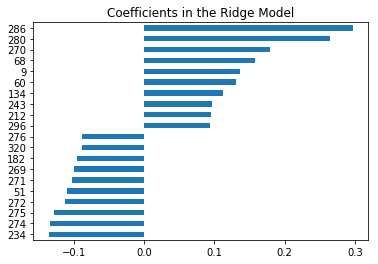

In [8]:
#作业这一步不是必须
print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                store_cv_values=True)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

mse_cv = np.mean(ridge.cv_values_, axis = 0)
rmse_cv = np.sqrt(mse_cv)
print("cv of rmse :", min(rmse_cv))

y_train_rdg = ridge.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train,y_train_rdg))
print("RMSE on Training set :", rmse_train)


# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")

#正系数值最大的10个特征和负系数值最小（绝对值大）的10个特征
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

**3* Linear Regression with Lasso regularization (L1 penalty)**

/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


('Best alpha :', 0.001)
Try again for more precision with alphas centered around 0.001
('Best alpha :', 0.0010500000000000002)
('cv of rmse :', 0.28353734545829701)
('RMSE on Training set :', 0.27531394757319033)
Lasso picked 129 features and eliminated the other 214 features


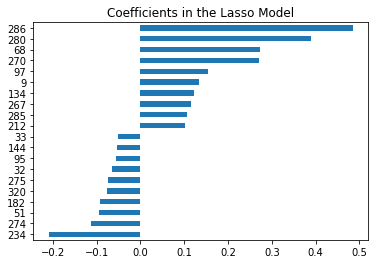

In [9]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                max_iter = 5000)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

mse_cv = np.mean(lasso.mse_path_, axis = 0)
rmse_cv = np.sqrt(mse_cv)
print("cv of rmse :", min(rmse_cv))

y_train_lasso = lasso.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train,y_train_lasso))
print("RMSE on Training set :", rmse_train)

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

## 对测试集进行测试，生成提交文件

In [10]:
y_test_pred = lasso.predict(X_test)
y_test_pred = y_test_pred * std_y +  mean_y

#生成提交测试结果

#df = pd.DataFrame({"Id":test_Id, 'SalePrice':y_test_pred})
#df.reindex(columns=['Id'])
y = pd.Series(data = y_test_pred, name = 'SalePrice')
df = pd.concat([test_Id, y], axis = 1)
df.to_csv('submission.csv')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
Id           1459 non-null int64
SalePrice    1459 non-null float64
dtypes: float64(1), int64(1)
memory usage: 22.9 KB
